In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

basins=load_basins_data()

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

In [3]:
data_TWS='GRACE_JPL_mascons'
TWSC_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_idx=pd.date_range('2003-03-01','2014-12-01',freq='SM')[::2]

In [4]:
basins_gamma=basins.copy()
for basin_name in basins_gamma.index:
    TWSC_filter=TWSC_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
    TWSC_filter.index=time_idx
    # RMSE with the long-term mean
    err_cst=np.sqrt(np.sum((TWSC_filter-TWSC_filter.mean())**2)/TWSC_filter.shape[0])

    # compute the mean value per month
    TWSC_df=TWSC_filter.to_frame()
    TWSC_df['month']=TWSC_df.index.month
    TWSC_mean=TWSC_df.groupby('month').mean()
    TWSC_mean.columns=['mean month']

    # associate each date to the mean monthly value
    TWSC_df=TWSC_df.join(TWSC_mean,on='month')
    err_cycle=np.sqrt(np.sum((TWSC_filter-TWSC_df['mean month'])**2)/TWSC_filter.shape[0])
    
    basins_gamma.loc[basin_name,'err cst']=err_cst
    basins_gamma.loc[basin_name,'err cycle']=err_cycle
    basins_gamma.loc[basin_name,'gamma']=(err_cst/err_cycle)**2
    basins_gamma.loc[basin_name,'amplitude']=0.5*(TWSC_df['mean month'].max()-TWSC_df['mean month'].min())

<IPython.core.display.Javascript object>


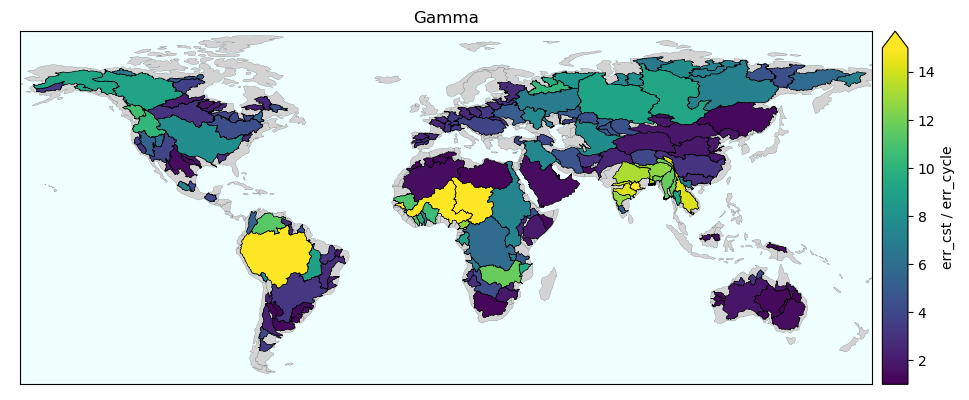

In [5]:
fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_gamma.plot(ax=ax,column='gamma',edgecolor='black',linewidth=0.4,
                 vmin=1,vmax=15,
                 legend=True,cax=cax,
                legend_kwds={'label': "err_cst / err_cycle",
                              'extend':'max'
                          },)

ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('Gamma')
plt.tight_layout()
plt.show()

Plot the mean monthly cycle in a given basin.

<IPython.core.display.Javascript object>


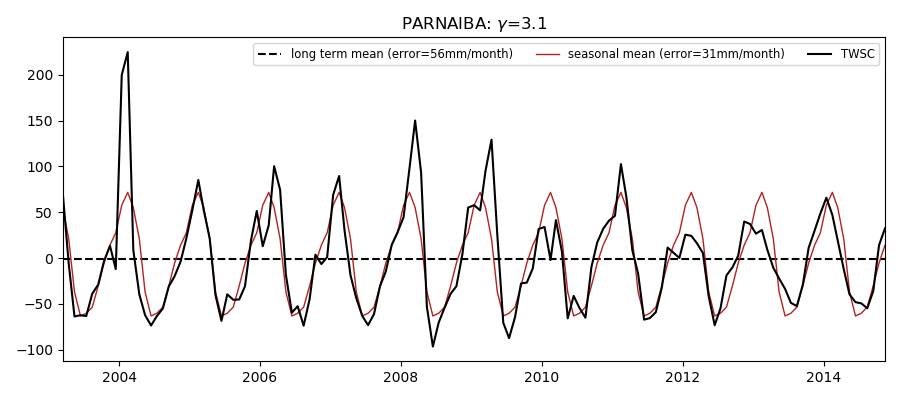

In [6]:
basin_name='PARNAIBA'
TWSC_filter=TWSC_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
TWSC_filter.index=time_idx

# compute the mean value per month
TWSC_df=TWSC_filter.to_frame()
TWSC_df['month']=TWSC_df.index.month
TWSC_mean=TWSC_df.groupby('month').mean()
TWSC_mean.columns=['mean month']
# associate each date to the mean monthly value
TWSC_df=TWSC_df.join(TWSC_mean,on='month')
    
plt.figure(figsize=(9,4))
plt.plot(pd.Series(TWSC_filter.mean(),index=time_idx),'k--',label='long term mean (error={:.0f}mm/month)'.format(basins_gamma.loc[basin_name,'err cst']))
plt.plot(TWSC_df['mean month'],color='firebrick',linewidth=1,
         label='seasonal mean (error={:.0f}mm/month)'.format(basins_gamma.loc[basin_name,'err cycle']))
plt.plot(TWSC_filter,'k',label='TWSC')
plt.xlim([time_idx[0],time_idx[-1]])
plt.legend(ncol=3,fontsize='small')
plt.title('{}: $\gamma$={:.1f}'.format(basin_name,basins_gamma.loc[basin_name,'gamma']))
plt.tight_layout()
plt.show()

cyclic NSE as a function of the NSE

<IPython.core.display.Javascript object>


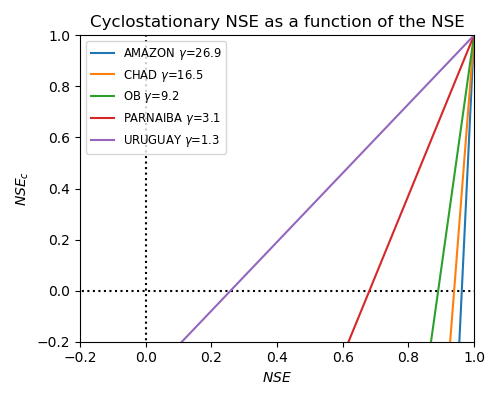

In [7]:
X=np.arange(-1,1.1,0.1)
plt.figure(figsize=(5,4))
plt.plot([-1,1],[0,0],'k:')
plt.plot([0,0],[-10,1],'k:')
for basin_name in ['AMAZON','CHAD','OB','PARNAIBA','URUGUAY']:
    gamma=basins_gamma.loc[basin_name,'gamma']
    plt.plot(X,1-gamma+gamma*X,label='{} $\gamma$={:.1f}'.format(basin_name.replace(' (DL)',''),gamma))
plt.xlim([-0.2,1])
plt.xlabel('$NSE$')
plt.ylim([-0.2,1])
plt.ylabel('$NSE_c$')
plt.title('Cyclostationary NSE as a function of the NSE')
plt.legend(loc='upper left',fontsize='small')
plt.tight_layout()
plt.show()

Save gamma, magnitude, and errors results

In [8]:
basins_gamma[['amplitude','gamma','err cycle']].to_csv('../results/basins_gamma.csv')